In [2]:
import os
import dill

import numpy as np
import scipy as sp

import TwoPUtils
import STX3KO_analyses as stx


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
def plot_trial_simmat(C,morph,vmax=None,vmin=None):
    '''Plot trial by trial similarity matrix, C. Produces three plots
    1) trials sorted by the order in which they occured
    2) trials sorted morph value
    3) trials are clustered by spectral clustering (assumes C is non-negative).
        Uses silhouette_score as a heuristic for choosing the number of clusters
    inputs: C - trial by trial similarity matrix (typically cosine similarity)
            trial_info - output of utilities.by_trial_info
            vmax - max for colormap
            vmin - min for colormap
    outputs: f, axlist - figure and axis objects
    '''

    if vmax is None:
        vmax = np.percentile(C.ravel(),90)
    if vmin is None:
        vmin = np.percentile(C.ravel(),10)


    f = plt.figure(figsize=[10,12])
    gs = gridspec.GridSpec(14,10)

    
    morph = (morph+.1)/1.2

    x=np.arange(morph.size)
    
    
    ###### sort by morph value
    cm_ax = f.add_subplot(gs[:10,0:10])
    cm_ax.imshow(C,cmap='Greys',vmin=vmin,vmax=vmax,aspect='auto')
    cm_ax.set_yticks([])
    cm_ax.set_xticks([])

    mm_ax = f.add_subplot(gs[10:12,0:10])
    mm_ax.scatter(x,morph,c=1-morph,cmap='cool')
    mm_ax.set_xlim([0,x.shape[0]])
    

    return f, [cm_ax,mm_ax]

def similarity_fraction(S_trial_mat,morph):
    '''
    calculate cosine similarity to average morph=1 represenation divided by the sum of cosine similarities to the two extremes
    similar to a coding direction but on unit circle
    inputs: S_trial_mat - [trials, position bins, neurons] numpy array of activity rates
            trial_info - dictionary of trial information. output of by_trial_info
    returns: sf - [trials,] numpy array of similarity fraction
    '''
    S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,2,axis=1) # smooth position by 1 bin

    #flatten to be trial x positions*neurons
    S_tmat = np.reshape(S_trial_mat,[S_trial_mat.shape[0],-1])
     # divide trials by l2-norm
    S_tmat_norm = S_tmat/np.linalg.norm(S_tmat,ord=2,axis=-1)[:,np.newaxis]

    sf = np.zeros(morph.shape[0]) # similarity fraction
    for trial in range(morph.shape[0]): # for each trial
        # get masks for centroids
        mask0 = morph==0
        mask1 = morph==1
        # if current trial is in mask, exclude it
        if morph[trial]==0:
            mask0[trial]=False
        elif morph[trial]==1:
            mask1[trial]=False

        # calculate centroids
        centroid0, centroid1 = np.nanmean(S_tmat[mask0,:],axis=0), np.nanmean(S_tmat[mask1,:],axis=0)
        # cd = centroid1 - centroid0
        # cd = cd/np.linalg.norm(cd,ord=2)
        centroid0=centroid0/np.linalg.norm(centroid0,ord=2)
        centroid1=centroid1/np.linalg.norm(centroid1,ord=2)



        # similarity to two centroids
        angle0,angle1 = np.dot(S_tmat_norm[trial,:],centroid0),np.dot(S_tmat_norm[trial,:],centroid1)
        # whole trial similarity fraction
        sf[trial] = angle1/(angle0+angle1)
        # sf[trial] = np.dot(cd,S_tmat[trial,:])
    return sf

In [7]:
basedir = os.path.join("/home/mplitt/MorphSessPkls")
mouse = '4467975.4'


sess_list = []
for deets in stx.morph_sess_deets.KO_sessions[mouse]:
    print(deets)
    with open(os.path.join(basedir,mouse, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session'])),'rb') as file:
        sess = dill.load(file)
    sess_list.append(sess)

{'date': '09_10_2020', 'scene': 'TwoTower_foraging', 'session': 2, 'scan': 3}
{'date': '11_10_2020', 'scene': 'TwoTower_foraging', 'session': 2, 'scan': 3}
{'date': '13_10_2020', 'scene': 'TwoTower_foraging', 'session': 4, 'scan': 10}
{'date': '14_10_2020', 'scene': 'TwoTower_foraging', 'session': 2, 'scan': 3}
{'date': '15_10_2020', 'scene': 'TwoTower_foraging', 'session': 2, 'scan': 7}
{'date': '16_10_2020', 'scene': 'TwoTower_foraging', 'session': 3, 'scan': 6}
{'date': '17_10_2020', 'scene': 'TwoTower_foraging', 'session': 2, 'scan': 3}


(90, 45, 1525)
(60, 45, 1577)
(60, 45, 1412)
(90, 45, 1762)
(90, 45, 1234)
(90, 45, 1321)
(120, 45, 1036)


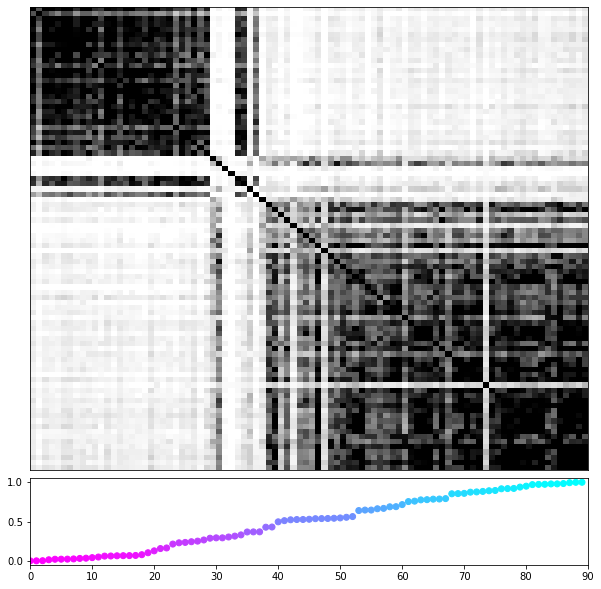

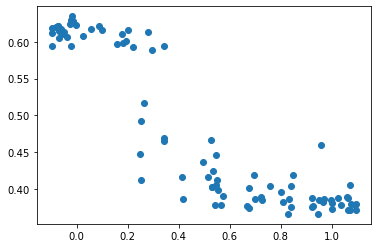

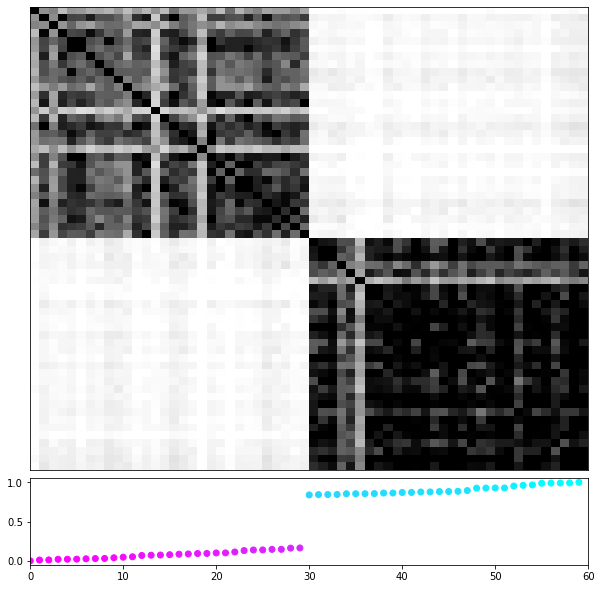

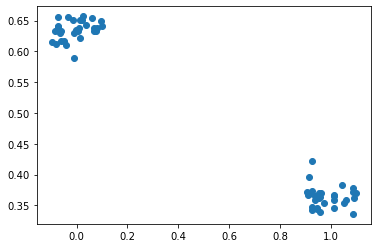

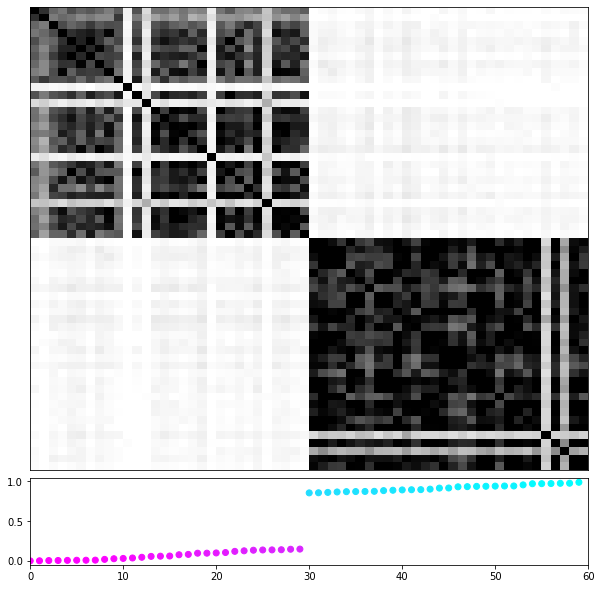

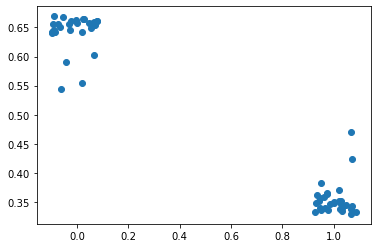

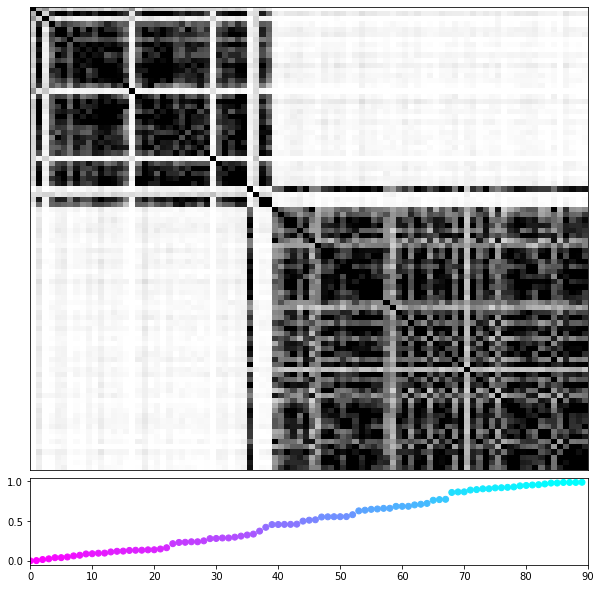

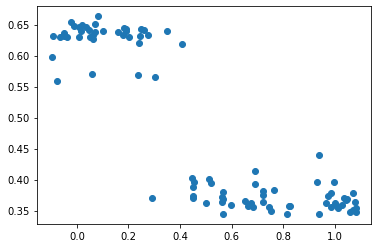

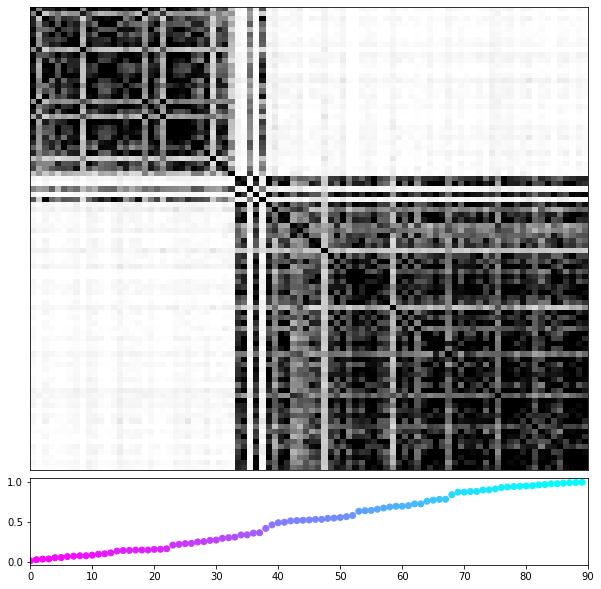

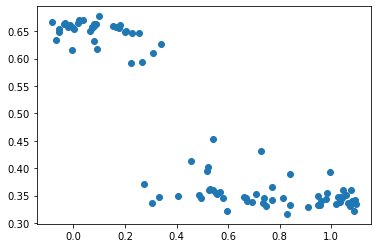

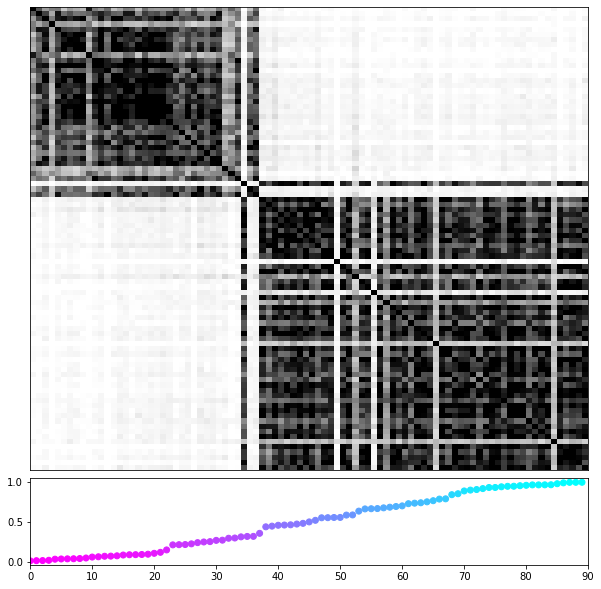

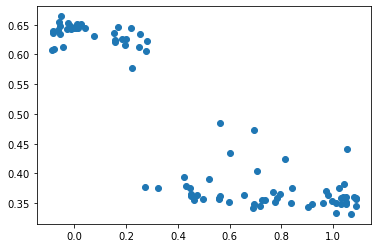

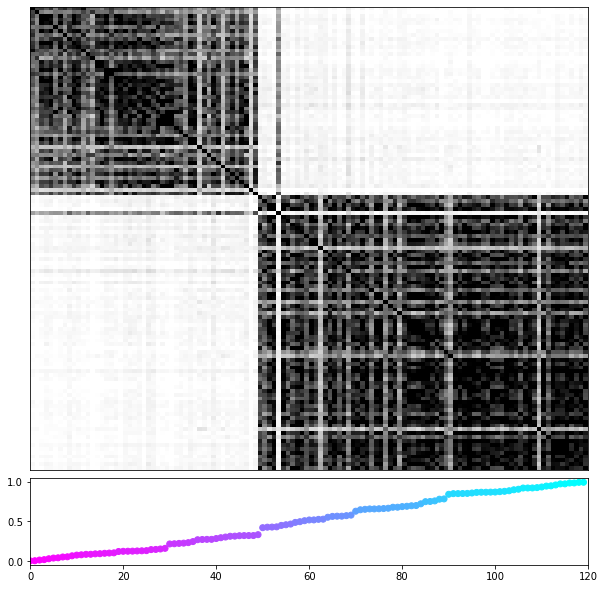

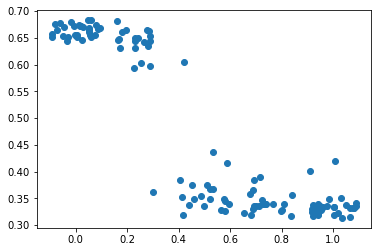

In [8]:
for sess in sess_list:
    
    sess.add_pos_binned_trial_matrix('spks','pos', mat_only=True)
    trial_mat = sess.trial_matrices['spks']
    trial_mat[np.isnan(trial_mat)] = 0
    trial_mat = sp.ndimage.filters.gaussian_filter1d(sess.trial_matrices['spks'],1,axis=1)
    trial_mat_flat = np.reshape(trial_mat,[trial_mat.shape[0], -1])
    trial_mat_flat = trial_mat_flat/np.linalg.norm(trial_mat_flat, ord=2, axis=-1)[:,np.newaxis]
    
    morph_sort = np.argsort(sess.trial_info['morph'])
    
    trial_mat_flat = trial_mat_flat[morph_sort,:]
    sm = np.matmul(trial_mat_flat,trial_mat_flat.T)
    
    
    fig,axlist = plot_trial_simmat(sm,sess.trial_info['morph'][morph_sort])
    fig_dir = os.path.join("/home/mplitt/Fig_scratch/Morph/trial_simmats",mouse)
    os.makedirs(fig_dir,exist_ok=True)
    fig.savefig(os.path.join(fig_dir,"%s_%d.pdf" %(sess.date,sess.session)),format='pdf')
    
    sf = similarity_fraction(sess.trial_matrices['spks'], sess.trial_info['morph_shared'])
    fig,ax = plt.subplots()
    ax.scatter(sess.trial_info['morph'],1-sf)
    print(trial_mat.shape)